In [ ]:
## filters for cocnut only
class_map = {"Coconut": 0}


In [1]:
import geopandas as gpd

def geojson_to_yolo_coconut(
    tile_geojson_path,
    output_txt_path,
):
    gdf = gpd.read_file(tile_geojson_path)

    if gdf.empty:
        open(output_txt_path, "w").close()
        return

    minx, miny, maxx, maxy = gdf.total_bounds
    tile_w = maxx - minx
    tile_h = maxy - miny

    yolo_lines = []

    for _, row in gdf.iterrows():
        if row.get("species_mapped") != "Coconut":
            continue

        geom = row.geometry
        bx_min, by_min, bx_max, by_max = geom.bounds

        x_center = ((bx_min + bx_max) / 2 - minx) / tile_w
        y_center = ((by_min + by_max) / 2 - miny) / tile_h
        w = (bx_max - bx_min) / tile_w
        h = (by_max - by_min) / tile_h

        # YOLO coordinate flip
        y_center = 1 - y_center

        # filter tiny boxes
        if w < 0.01 or h < 0.01:
            continue

        yolo_lines.append(
            f"0 {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}"
        )

    with open(output_txt_path, "w") as f:
        f.write("\n".join(yolo_lines))


In [2]:
import os

input_dir = "labels/geojson"
output_dir = "labels/yoloCoconut"

os.makedirs(output_dir, exist_ok=True)

for fname in os.listdir(input_dir):
    if fname.endswith(".geojson"):
        geojson_path = os.path.join(input_dir, fname)
        txt_path = os.path.join(
            output_dir,
            fname.replace(".geojson", ".txt")
        )

        geojson_to_yolo_coconut(geojson_path, txt_path)


### splitting data

In [9]:
import os
import random
import shutil

random.seed(42)

imge_dir = "images_png"
labels = "labels/yoloCoconut"
output = "dataset"

splits = {
    "train": 0.7,
    "val": 0.2,
    "test": 0.1
}

images = [f for f in os.listdir(imge_dir) if f.endswith(".png")]
random.shuffle(images)

n = len(images)
train_end = int(splits["train"] * n)
val_end = train_end + int(splits["val"] * n)

split_map = {
    "train": images[:train_end],
    "val": images[train_end:val_end],
    "test": images[val_end:]
}

for split, files in split_map.items():
    os.makedirs(f"{output}/images/{split}", exist_ok=True)
    os.makedirs(f"{output}/labels/{split}", exist_ok=True)

    for img in files:
        lbl = img.replace(".png", ".txt")

        shutil.copy(
            f"{imge_dir}/{img}",
            f"{output}/images/{split}/{img}"
        )

        if os.path.exists(f"{labels}/{lbl}"):
            shutil.copy(
                f"{labels}/{lbl}",
                f"{output}/labels/{split}/{lbl}"
            )


In [10]:
!uv pip install ultralytics


Using Python 3.12.11 environment at: /Users/saharmohamed/Documents/UBS_Material/DL4CV/.venv
Resolved 35 packages in 489ms                                        
⠙ Preparing packages... (0/9)                                                   
⠙ Preparing packages... (0/9)--------------     0 B/16.31 KiB           
⠙ Preparing packages... (0/9)--------------     0 B/16.31 KiB           
filelock             ------------------------------     0 B/16.31 KiB
⠙ Preparing packages... (0/9)--------------     0 B/128.50 KiB          
filelock             ------------------------------     0 B/16.31 KiB
⠙ Preparing packages... (0/9)-------------- 14.88 KiB/128.50 KiB        
filelock             ------------------------------     0 B/16.31 KiB
⠙ Preparing packages... (0/9)-------------- 14.88 KiB/128.50 KiB        
filelock             ------------------------------     0 B/16.31 KiB
⠙ Preparing packages... (0/9)-------------- 14.88 KiB/128.50 KiB        
filelock             ------------------

In [14]:
!uv pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision

In [16]:
! uv pip install huggingface_hub

Using Python 3.12.11 environment at: /Users/saharmohamed/Documents/UBS_Material/DL4CV/.venv
Resolved 17 packages in 375ms                                        
⠙ Preparing packages... (0/5)                                                   
⠙ Preparing packages... (0/5)--------------     0 B/9.53 KiB            
⠙ Preparing packages... (0/5)--------------     0 B/9.53 KiB            
shellingham          ------------------------------     0 B/9.53 KiB
⠙ Preparing packages... (0/5)--------------     0 B/110.93 KiB          
shellingham          ------------------------------     0 B/9.53 KiB
⠙ Preparing packages... (0/5)-------------- 14.88 KiB/110.93 KiB        
shellingham          ------------------------------     0 B/9.53 KiB
⠙ Preparing packages... (0/5)-------------- 30.88 KiB/110.93 KiB        
shellingham          ------------------------------     0 B/9.53 KiB
⠙ Preparing packages... (0/5)-------------- 46.88 KiB/110.93 KiB        
shellingham          ----------------------

## note ya Sahar for mac add >>> device="mps"

In [36]:
import numpy as np
if not hasattr(np, "trapz"):
    np.trapz = np.trapezoid
    
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data= '/Users/saharmohamed/Documents/UBS_Material/DL4CV/dl4cv-object-detection-on-aerial-imagery/notebooks/dataset/dataset.yaml', imgsz=256, batch=16, epochs=100)


New https://pypi.org/project/ultralytics/8.3.251 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.12.11 torch-2.9.1 CPU (Apple M4)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/Users/saharmohamed/Documents/UBS_Material/DL4CV/dl4cv-object-detection-on-aerial-imagery/notebooks/dataset/dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_

train: Scanning /Users/saharmohamed/Documents/UBS_Material/DL4CV/dl4cv-object-detection-on-aerial-imagery/notebooks/dataset/labels/train.cache... 385 images, 69 backgrounds, 0 corrupt: 100%|██████████| 385/385 [00:00<?, ?it/s]
/Users/saharmohamed/Documents/UBS_Material/DL4CV/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning /Users/saharmohamed/Documents/UBS_Material/DL4CV/dl4cv-object-detection-on-aerial-imagery/notebooks/dataset/labels/val.cache... 110 images, 18 backgrounds, 0 corrupt: 100%|██████████| 110/110 [00:00<?, ?it/s]


Plotting labels to runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 0 dataloader workers
Logging results to runs/detect/train6
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      5.127      4.575      4.128         12        256: 100%|██████████| 25/25 [01:33<00:00,  3.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.76s/it]

                   all        110       2328    0.00142     0.0043    0.00092   0.000612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      5.654      4.206      3.915          1        256: 100%|██████████| 25/25 [01:28<00:00,  3.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:15<00:00,  3.91s/it]

                   all        110       2328   0.000864     0.0112   0.000646   0.000395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      5.556      3.402      3.255         56        256: 100%|██████████| 25/25 [01:28<00:00,  3.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.37s/it]

                   all        110       2328   0.000667    0.00945    0.00069    0.00047



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G       4.21      2.494      2.264          0        256: 100%|██████████| 25/25 [01:16<00:00,  3.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.21s/it]

                   all        110       2328    0.00072    0.00816   0.000382   0.000234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      4.153      2.219      1.841         39        256: 100%|██████████| 25/25 [02:12<00:00,  5.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.27s/it]

                   all        110       2328     0.0249    0.00172    0.00147   0.000552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      3.932      2.157      1.743         59        256: 100%|██████████| 25/25 [01:29<00:00,  3.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.34s/it]

                   all        110       2328      0.148      0.102     0.0499     0.0132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      3.807      2.064      1.612         64        256: 100%|██████████| 25/25 [01:19<00:00,  3.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:16<00:00,  4.15s/it]

                   all        110       2328      0.185      0.231      0.112     0.0302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      3.569      1.992       1.58         20        256: 100%|██████████| 25/25 [01:42<00:00,  4.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.25s/it]

                   all        110       2328      0.205      0.293      0.141     0.0416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      3.431      1.958       1.57         11        256: 100%|██████████| 25/25 [01:29<00:00,  3.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.56s/it]

                   all        110       2328      0.292       0.34      0.221     0.0631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      3.318      1.882      1.494         33        256: 100%|██████████| 25/25 [01:18<00:00,  3.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.47s/it]

                   all        110       2328      0.301      0.341      0.216     0.0638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      3.165      1.921      1.505          8        256: 100%|██████████| 25/25 [01:42<00:00,  4.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:19<00:00,  4.85s/it]

                   all        110       2328      0.312       0.33      0.213     0.0617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      3.068      1.792      1.409         58        256: 100%|██████████| 25/25 [02:17<00:00,  5.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:16<00:00,  4.15s/it]

                   all        110       2328      0.432      0.396      0.312      0.097



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      3.052       1.79      1.395         64        256: 100%|██████████| 25/25 [01:37<00:00,  3.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.67s/it]

                   all        110       2328     0.0712      0.115     0.0335    0.00742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      2.989      1.767      1.346         70        256: 100%|██████████| 25/25 [01:31<00:00,  3.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.54s/it]

                   all        110       2328      0.186      0.245      0.106     0.0218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      2.849      1.723      1.343         24        256: 100%|██████████| 25/25 [01:46<00:00,  4.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.71s/it]

                   all        110       2328      0.506      0.423      0.372      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G      2.789      1.711      1.369         13        256: 100%|██████████| 25/25 [01:28<00:00,  3.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:14<00:00,  3.59s/it]

                   all        110       2328      0.176      0.144     0.0729     0.0127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      2.759      1.648      1.302         61        256: 100%|██████████| 25/25 [01:22<00:00,  3.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.58s/it]

                   all        110       2328      0.202      0.226      0.106      0.016



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G      2.753       1.59      1.272         38        256: 100%|██████████| 25/25 [01:35<00:00,  3.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:13<00:00,  3.42s/it]

                   all        110       2328     0.0364     0.0722     0.0107    0.00227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G       2.82      1.627      1.333         66        256: 100%|██████████| 25/25 [01:18<00:00,  3.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.77s/it]

                   all        110       2328      0.566       0.53      0.438      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G      2.727      1.599      1.287         22        256: 100%|██████████| 25/25 [01:28<00:00,  3.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.98s/it]

                   all        110       2328     0.0683      0.144     0.0311    0.00517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G      2.676      1.632      1.285         32        256: 100%|██████████| 25/25 [01:38<00:00,  3.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.48s/it]

                   all        110       2328     0.0826      0.116     0.0331    0.00467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G      2.572      1.554      1.269         32        256: 100%|██████████| 25/25 [01:18<00:00,  3.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:13<00:00,  3.34s/it]

                   all        110       2328     0.0478     0.0849     0.0191    0.00314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      2.569      1.539      1.266         23        256: 100%|██████████| 25/25 [01:40<00:00,  4.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.75s/it]

                   all        110       2328     0.0574     0.0782     0.0162    0.00238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      2.522      1.518      1.264         16        256: 100%|██████████| 25/25 [01:40<00:00,  4.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:18<00:00,  4.75s/it]

                   all        110       2328      0.335      0.264      0.172     0.0322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G      2.616      1.656      1.306         12        256: 100%|██████████| 25/25 [01:47<00:00,  4.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.76s/it]

                   all        110       2328     0.0628     0.0636     0.0185    0.00289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      2.495      1.491      1.228         46        256: 100%|██████████| 25/25 [01:31<00:00,  3.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.84s/it]

                   all        110       2328      0.012     0.0318    0.00263    0.00044



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G      2.485      1.536       1.23         33        256: 100%|██████████| 25/25 [01:26<00:00,  3.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:16<00:00,  4.04s/it]

                   all        110       2328      0.241      0.248      0.111     0.0168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G      2.402      1.458      1.197         18        256: 100%|██████████| 25/25 [01:39<00:00,  3.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.20s/it]

                   all        110       2328      0.253      0.218      0.112     0.0188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G      2.424      1.553      1.263         10        256: 100%|██████████| 25/25 [01:40<00:00,  4.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.69s/it]

                   all        110       2328      0.461      0.424      0.307     0.0637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G      2.356      1.456      1.205         38        256: 100%|██████████| 25/25 [01:31<00:00,  3.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.02s/it]

                   all        110       2328     0.0817     0.0816     0.0198    0.00283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G      2.466      1.446      1.185         59        256: 100%|██████████| 25/25 [02:32<00:00,  6.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:16<00:00,  4.17s/it]

                   all        110       2328     0.0933     0.0966      0.025    0.00381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G        2.4      1.609      1.274          6        256: 100%|██████████| 25/25 [02:17<00:00,  5.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:14<00:00,  3.65s/it]

                   all        110       2328     0.0223     0.0399    0.00463   0.000753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G       2.38      1.453      1.234         22        256: 100%|██████████| 25/25 [02:02<00:00,  4.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.19s/it]

                   all        110       2328      0.149      0.147     0.0518    0.00675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G      2.527      1.684      1.278          8        256: 100%|██████████| 25/25 [02:28<00:00,  5.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:16<00:00,  4.14s/it]

                   all        110       2328      0.357      0.345        0.2     0.0334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G      2.357      1.431      1.199         26        256: 100%|██████████| 25/25 [02:18<00:00,  5.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:14<00:00,  3.73s/it]

                   all        110       2328      0.291      0.246      0.133     0.0245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G      2.468      1.505      1.308         23        256: 100%|██████████| 25/25 [02:12<00:00,  5.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:24<00:00,  6.24s/it]

                   all        110       2328     0.0235     0.0357    0.00618    0.00085



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G      2.332      1.389      1.169         22        256: 100%|██████████| 25/25 [02:42<00:00,  6.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:15<00:00,  3.90s/it]

                   all        110       2328      0.105      0.116     0.0334    0.00493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G      2.332       1.42      1.189         10        256: 100%|██████████| 25/25 [02:15<00:00,  5.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:13<00:00,  3.36s/it]

                   all        110       2328      0.491      0.513      0.361     0.0923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G      2.312      1.406      1.162         97        256: 100%|██████████| 25/25 [02:30<00:00,  6.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:23<00:00,  5.79s/it]

                   all        110       2328      0.141       0.14     0.0447     0.0064



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G      2.316      1.402      1.186         47        256: 100%|██████████| 25/25 [03:41<00:00,  8.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:22<00:00,  5.61s/it]

                   all        110       2328      0.439      0.414      0.303     0.0627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G      2.339      1.431      1.203         14        256: 100%|██████████| 25/25 [02:19<00:00,  5.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:19<00:00,  4.86s/it]

                   all        110       2328     0.0611     0.0795     0.0145    0.00199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G      2.351      1.352      1.164         72        256: 100%|██████████| 25/25 [01:28<00:00,  3.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.37s/it]

                   all        110       2328      0.152      0.154     0.0475    0.00735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G      2.442      1.555      1.245          6        256: 100%|██████████| 25/25 [02:04<00:00,  4.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:18<00:00,  4.69s/it]

                   all        110       2328      0.276       0.26      0.133     0.0208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G      2.417      1.406      1.183         39        256: 100%|██████████| 25/25 [01:57<00:00,  4.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.20s/it]

                   all        110       2328     0.0819      0.104      0.023     0.0035



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G      2.392      1.542      1.205          5        256: 100%|██████████| 25/25 [01:34<00:00,  3.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:20<00:00,  5.18s/it]

                   all        110       2328      0.275      0.256      0.145     0.0243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G      2.291      1.372       1.19         29        256: 100%|██████████| 25/25 [02:47<00:00,  6.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:17<00:00,  4.28s/it]

                   all        110       2328      0.243      0.215      0.124     0.0223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G      2.305      1.368      1.184         39        256: 100%|██████████| 25/25 [02:53<00:00,  6.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:16<00:00,  4.21s/it]

                   all        110       2328     0.0172     0.0322    0.00416   0.000598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G      2.417      1.441      1.203         98        256: 100%|██████████| 25/25 [02:45<00:00,  6.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:19<00:00,  4.83s/it]

                   all        110       2328      0.325      0.381        0.2     0.0338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G      2.385      1.569      1.208          4        256: 100%|██████████| 25/25 [02:46<00:00,  6.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:17<00:00,  4.43s/it]

                   all        110       2328      0.357      0.385      0.211     0.0348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G      2.257      1.442      1.168          3        256: 100%|██████████| 25/25 [11:56<00:00, 28.67s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:25<00:00,  6.36s/it]

                   all        110       2328       0.22      0.221     0.0865     0.0125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G       2.32      1.387      1.174         35        256: 100%|██████████| 25/25 [15:42<00:00, 37.71s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.89s/it]

                   all        110       2328      0.161      0.159     0.0533    0.00739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G      2.295      1.329      1.165         35        256: 100%|██████████| 25/25 [01:48<00:00,  4.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:13<00:00,  3.37s/it]

                   all        110       2328      0.216      0.204     0.0884     0.0132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G      2.258      1.364      1.184         77        256: 100%|██████████| 25/25 [02:03<00:00,  4.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:16<00:00,  4.10s/it]

                   all        110       2328     0.0235     0.0378    0.00531    0.00081



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G      2.256      1.391      1.169         17        256: 100%|██████████| 25/25 [02:11<00:00,  5.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:14<00:00,  3.73s/it]

                   all        110       2328      0.189      0.188     0.0713     0.0108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G      2.321      1.436      1.175          9        256: 100%|██████████| 25/25 [01:49<00:00,  4.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.18s/it]

                   all        110       2328      0.278      0.273      0.136     0.0218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G      2.319      1.415      1.182         13        256: 100%|██████████| 25/25 [01:54<00:00,  4.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:14<00:00,  3.54s/it]

                   all        110       2328     0.0835      0.147     0.0275    0.00555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G       2.32      1.413      1.207         43        256: 100%|██████████| 25/25 [02:22<00:00,  5.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:19<00:00,  4.96s/it]

                   all        110       2328      0.239      0.258      0.108     0.0169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G      2.271      1.407      1.148         16        256: 100%|██████████| 25/25 [01:45<00:00,  4.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:16<00:00,  4.07s/it]

                   all        110       2328      0.477      0.466       0.32     0.0599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G       2.26      1.389      1.173          7        256: 100%|██████████| 25/25 [01:47<00:00,  4.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:15<00:00,  3.89s/it]

                   all        110       2328     0.0133     0.0176    0.00252   0.000359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G      2.183      1.292      1.144         20        256: 100%|██████████| 25/25 [01:57<00:00,  4.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:15<00:00,  3.92s/it]

                   all        110       2328      0.492      0.475      0.341      0.062



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G      2.227      1.377      1.158         37        256: 100%|██████████| 25/25 [01:46<00:00,  4.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:15<00:00,  3.80s/it]

                   all        110       2328      0.103      0.126     0.0298    0.00418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G      2.191       1.29      1.139         27        256: 100%|██████████| 25/25 [02:13<00:00,  5.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:15<00:00,  3.77s/it]

                   all        110       2328      0.403      0.378      0.247     0.0459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G      2.219      1.359      1.163         20        256: 100%|██████████| 25/25 [01:57<00:00,  4.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.06s/it]

                   all        110       2328     0.0341     0.0477    0.00685    0.00107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G      2.208      1.334      1.156         12        256: 100%|██████████| 25/25 [01:59<00:00,  4.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.24s/it]

                   all        110       2328      0.492      0.535      0.369      0.086



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G      2.206      1.427      1.164          7        256: 100%|██████████| 25/25 [01:58<00:00,  4.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.14s/it]

                   all        110       2328      0.437      0.479      0.294     0.0617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G      2.177      1.309      1.124         41        256: 100%|██████████| 25/25 [01:50<00:00,  4.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:13<00:00,  3.29s/it]

                   all        110       2328     0.0398     0.0481    0.00806     0.0012



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G      2.275       1.56      1.173          6        256: 100%|██████████| 25/25 [01:38<00:00,  3.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.83s/it]

                   all        110       2328      0.191      0.179     0.0679     0.0103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G      2.214      1.354      1.154         33        256: 100%|██████████| 25/25 [01:26<00:00,  3.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:13<00:00,  3.41s/it]

                   all        110       2328     0.0161     0.0206    0.00267    0.00041



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G      2.259      1.367       1.17         59        256: 100%|██████████| 25/25 [02:11<00:00,  5.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:14<00:00,  3.66s/it]

                   all        110       2328       0.38      0.357      0.225     0.0392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G      2.204      1.361      1.174          5        256: 100%|██████████| 25/25 [02:09<00:00,  5.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:14<00:00,  3.58s/it]

                   all        110       2328     0.0728     0.0739      0.016    0.00239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G      2.224        1.3       1.16         22        256: 100%|██████████| 25/25 [02:22<00:00,  5.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:16<00:00,  4.06s/it]

                   all        110       2328      0.325      0.317      0.177     0.0277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G      2.215      1.384      1.148         38        256: 100%|██████████| 25/25 [02:32<00:00,  6.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:17<00:00,  4.50s/it]

                   all        110       2328       0.32      0.322      0.171     0.0264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G      2.194      1.286      1.137         28        256: 100%|██████████| 25/25 [02:14<00:00,  5.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:16<00:00,  4.14s/it]

                   all        110       2328      0.598      0.564      0.471      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G      2.221      1.317      1.136         26        256: 100%|██████████| 25/25 [01:56<00:00,  4.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:13<00:00,  3.34s/it]

                   all        110       2328      0.047     0.0554      0.011    0.00157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G      2.181      1.334      1.135         39        256: 100%|██████████| 25/25 [01:58<00:00,  4.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:17<00:00,  4.25s/it]

                   all        110       2328      0.258      0.267      0.121     0.0194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G      2.309      1.391      1.186         53        256: 100%|██████████| 25/25 [02:02<00:00,  4.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:13<00:00,  3.27s/it]

                   all        110       2328      0.264      0.275      0.126     0.0201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         0G      2.302      1.338       1.14         89        256: 100%|██████████| 25/25 [01:58<00:00,  4.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:13<00:00,  3.29s/it]

                   all        110       2328      0.462      0.437      0.307     0.0559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         0G      2.218      1.337      1.129          8        256: 100%|██████████| 25/25 [02:00<00:00,  4.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:14<00:00,  3.57s/it]

                   all        110       2328     0.0868     0.0966     0.0231    0.00341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100         0G      2.199      1.323      1.143         19        256: 100%|██████████| 25/25 [01:59<00:00,  4.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:15<00:00,  3.75s/it]

                   all        110       2328      0.416      0.399      0.258     0.0385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100         0G      2.248      2.101      1.166          2        256: 100%|██████████| 25/25 [01:50<00:00,  4.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.00s/it]

                   all        110       2328      0.267      0.308      0.137     0.0216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         0G      2.226      1.746      1.188          1        256: 100%|██████████| 25/25 [01:50<00:00,  4.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:15<00:00,  3.98s/it]

                   all        110       2328      0.373      0.357      0.208     0.0329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         0G      2.204      1.319      1.155         51        256: 100%|██████████| 25/25 [01:46<00:00,  4.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:13<00:00,  3.35s/it]

                   all        110       2328      0.478      0.458      0.325     0.0624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100         0G      2.211       1.33      1.141         36        256: 100%|██████████| 25/25 [01:45<00:00,  4.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:14<00:00,  3.64s/it]

                   all        110       2328      0.229      0.227     0.0942     0.0143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100         0G      2.185      1.299      1.161         20        256: 100%|██████████| 25/25 [01:54<00:00,  4.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.93s/it]

                   all        110       2328       0.32      0.302      0.162     0.0253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100         0G      2.179      1.351      1.144         65        256: 100%|██████████| 25/25 [01:23<00:00,  3.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.57s/it]

                   all        110       2328       0.18      0.184     0.0655    0.00942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G      2.151      1.319      1.135         31        256: 100%|██████████| 25/25 [01:20<00:00,  3.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.61s/it]

                   all        110       2328      0.233      0.239     0.0997     0.0144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         0G      2.198      1.322      1.146         30        256: 100%|██████████| 25/25 [01:32<00:00,  3.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.72s/it]

                   all        110       2328      0.197      0.199     0.0751     0.0101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100         0G      2.153      1.341      1.124         11        256: 100%|██████████| 25/25 [01:27<00:00,  3.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.70s/it]

                   all        110       2328      0.476      0.454      0.329     0.0611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         0G      2.153      1.289      1.123         52        256: 100%|██████████| 25/25 [01:34<00:00,  3.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.05s/it]

                   all        110       2328      0.334      0.312      0.178      0.027



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         0G      2.196      1.377      1.162         12        256: 100%|██████████| 25/25 [01:36<00:00,  3.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.78s/it]

                   all        110       2328        0.4      0.381      0.241     0.0403


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/Users/saharmohamed/Documents/UBS_Material/DL4CV/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
     91/100         0G      1.984      1.973      1.088          0        256: 100%|██████████| 25/25 [01:22<00:00,  3.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.68s/it]

                   all        110       2328      0.415      0.439      0.282     0.0557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         0G      1.991      1.286      1.114         25        256: 100%|██████████| 25/25 [01:20<00:00,  3.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.68s/it]

                   all        110       2328      0.443      0.452      0.309     0.0562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100         0G      2.074      1.834      1.203          1        256: 100%|██████████| 25/25 [01:31<00:00,  3.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.80s/it]

                   all        110       2328      0.543      0.518      0.407     0.0969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100         0G      2.067      1.326      1.118         52        256: 100%|██████████| 25/25 [01:26<00:00,  3.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.76s/it]

                   all        110       2328      0.478      0.455      0.331     0.0638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100         0G       2.04      1.318      1.139         22        256: 100%|██████████| 25/25 [01:36<00:00,  3.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.05s/it]

                   all        110       2328      0.334      0.334      0.178      0.026



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100         0G          2      1.305      1.116         43        256: 100%|██████████| 25/25 [01:40<00:00,  4.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.83s/it]

                   all        110       2328      0.377      0.389      0.226      0.037



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100         0G      1.884      1.847       1.07          0        256: 100%|██████████| 25/25 [01:27<00:00,  3.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.98s/it]

                   all        110       2328      0.399      0.407      0.245     0.0417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         0G      2.035      2.067      1.135          3        256: 100%|██████████| 25/25 [01:22<00:00,  3.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.83s/it]

                   all        110       2328       0.45      0.451      0.303     0.0579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100         0G      2.061       1.31      1.131         33        256: 100%|██████████| 25/25 [01:39<00:00,  3.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.91s/it]

                   all        110       2328      0.384      0.387      0.229     0.0403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100         0G      1.963      1.537      1.214          1        256: 100%|██████████| 25/25 [02:14<00:00,  5.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:14<00:00,  3.64s/it]

                   all        110       2328      0.354      0.365      0.202     0.0337



100 epochs completed in 3.936 hours.
Optimizer stripped from runs/detect/train6/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train6/weights/best.pt, 18.6MB

Validating runs/detect/train6/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.12.11 torch-2.9.1 CPU (Apple M4)
YOLOv12s summary (fused): 376 layers, 9,074,595 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.12s/it]


                   all        110       2328      0.566      0.527      0.438      0.156
Speed: 0.4ms preprocess, 90.3ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train6


### testing model

In [37]:
model = YOLO("runs/detect/train6/weights/best.pt")

#metrics = model.val(data="dataset.yaml", device="mps")


In [38]:
results = model.predict(
    source="dataset/images/test/OAM-6776-293593-19.png",
    imgsz=256,
    conf=0.25,
    device="mps",
    save=True
)



image 1/1 /Users/saharmohamed/Documents/UBS_Material/DL4CV/dl4cv-object-detection-on-aerial-imagery/notebooks/dataset/images/test/OAM-6776-293593-19.png: 256x256 42 coconuts, 30.9ms
Speed: 33.2ms preprocess, 30.9ms inference, 1881.4ms postprocess per image at shape (1, 3, 256, 256)
Results saved to runs/detect/predict


In [40]:
metrics = model.val(data="dataset/dataset.yaml", device="mps")

print("mAP50:", metrics.box.map50)
print("mAP50-95:", metrics.box.map)
print("Precision:", metrics.box.mp)
print("Recall:", metrics.box.mr)


Ultralytics 8.3.63 🚀 Python-3.12.11 torch-2.9.1 MPS (Apple M4)


val: Scanning /Users/saharmohamed/Documents/UBS_Material/DL4CV/dl4cv-object-detection-on-aerial-imagery/notebooks/dataset/labels/val.cache... 110 images, 18 backgrounds, 0 corrupt: 100%|██████████| 110/110 [00:00<?, ?it/s]
/Users/saharmohamed/Documents/UBS_Material/DL4CV/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:21<00:00,  3.08s/it]


                   all        110       2328      0.566      0.527      0.438      0.156
Speed: 5.5ms preprocess, 29.3ms inference, 0.0ms loss, 39.9ms postprocess per image
Results saved to runs/detect/val2
mAP50: 0.4375041614077489
mAP50-95: 0.15637901171237742
Precision: 0.5660684488386039
Recall: 0.5266323024054983


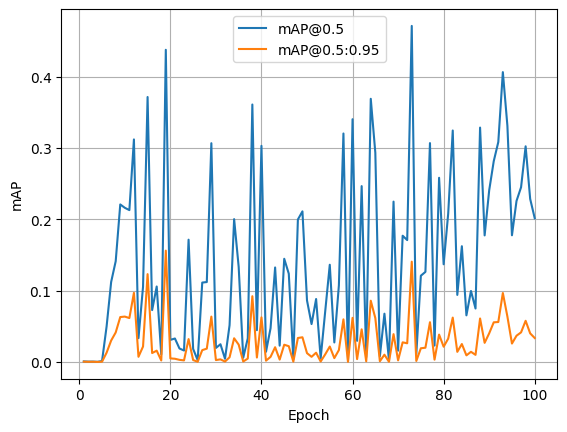

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("runs/detect/train6/results.csv")

plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP@0.5")
plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label="mAP@0.5:0.95")
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.legend()
plt.grid(True)
plt.show()
